(48, 48, 3)


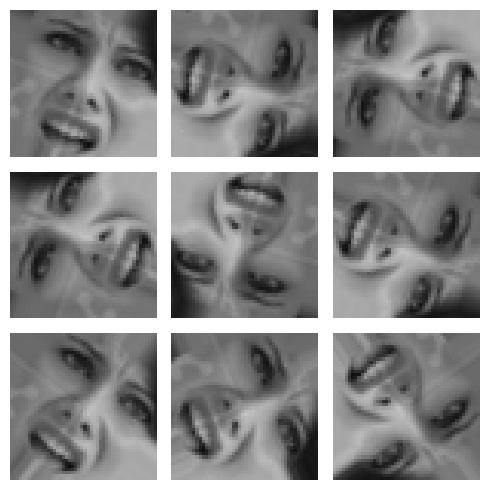

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

img = load_img('533.jpg')
img_array = img_to_array(img)
print(img_array.shape)

# Load the image
img = load_img('533.jpg')

# Convert the image to a numpy array
img_array = img_to_array(img)

# Create an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(rotation_range=180)

# Expand the dimensions of the numpy array
img_array = np.expand_dims(img_array, axis=0)

# Generate random rotated images
aug_iter = datagen.flow(img_array)

# Display 9 different rotated images
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5,5))

# Rotate the image 9 times
for ax in axs.flatten():
    augmented_image = next(aug_iter)[0].astype('uint8')
    # Save the image with a unique filename
    save_img(f'533_rotated_{ax}.jpg', augmented_image)
    ax.imshow(augmented_image)
    ax.axis('off')
    
plt.tight_layout()
plt.show()